# Sentiment Analysis of COVID Tweets

Ariana Puri, 20162450

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download datatattle/covid-19-nlp-text-classification

  0% 0.00/4.38M [00:00<?, ?B/s]
100% 4.38M/4.38M [00:00<00:00, 123MB/s]


In [6]:
! unzip covid-19-nlp-text-classification.zip

Archive:  covid-19-nlp-text-classification.zip
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


In [7]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import argparse

# Convert the output to a binary to simplify neural net
def convert_sentiment(data):
    new_data = data[data.Sentiment != 'Neutral']
    new_data = new_data.reset_index(drop=True)
    for x in range(0, len(new_data['Sentiment'])):
        if (new_data['Sentiment'][x] == 'Extremely Positive') or (new_data['Sentiment'][x] == 'Positive'):
            new_data['Sentiment'][x] = 1
        elif new_data['Sentiment'][x] == 'Negative' or new_data['Sentiment'][x] == 'Extremely Negative':
            new_data['Sentiment'][x] = 0

    return new_data
            

# Process the inputed tweets
def pre_process(line):
    new_words = []
    lem = nltk.WordNetLemmatizer()
    for word in line.split():
      # Remove links and user names
        if not (word == '' or word.startswith('http') or word.startswith('www') or word.startswith('@')):
            if word.startswith('#'):
                word = word[1:]
            word = ''.join(e for e in word if e.isalnum())
            word = word.lower()
            if word != '':
                # Find the root of the words
                word = lem.lemmatize(word)
                new_words.append(word)
    return bytes(' '.join(new_words), 'utf-8')

# tokenizes the tweets so that they can be input into the neural net
def encode(tweets):
  max_len = 500
  tok = Tokenizer()
  tok.fit_on_texts(tweets)
  sequences = tok.texts_to_sequences(tweets)
  num_words = len(tok.word_index) + 1
  return num_words, tok, sequences

# preprocess the data
def create_ds(file_location):
    data = pd.read_csv(file_location, encoding = "ISO-8859-1")
    data = data.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'])
    data = convert_sentiment(data)   
    for x in range(0, len(data['OriginalTweet'])):
        data['OriginalTweet'][x] = pre_process(data['OriginalTweet'][x]).decode("utf-8") 
    return data['OriginalTweet'], data['Sentiment'].to_numpy()

In [18]:
x_train, y_train  = create_ds("Corona_NLP_train.csv")
x_test, y_test  = create_ds("Corona_NLP_test.csv")

In [19]:
# Find the size of the vocabulary for the embedding layer
vocab_size, tok, x_train = encode(x_train)
x_test = tok.texts_to_sequences(x_test)

# Find the longest tweet for the vocabulary layer
max_len = max(len(x) for x in x_train)

# Pad tweets that are too short
for x in range(0, len(x_train)):
  if len(x_train[x]) < max_len:
    x_train[x].append(0) 

for x in range(0, len(x_test)):
  if len(x_test[x]) < max_len:
    x_test[x].append(0) 

In [20]:
# Convert the current lists into tensorflow data so that it can be used in the neural net
x_train = tf.ragged.constant(x_train, dtype = tf.int32)
y_train = tf.convert_to_tensor(y_train, dtype = tf.int32)
x_test = tf.ragged.constant(x_test, dtype = tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype = tf.int32)

In [21]:
# Build a neural net with an embedding layer, lstm layer, two 
def build_model(vocab_size, max_len, out_shape):
    new_model = tf.keras.Sequential(layers=None, name=None)
    new_model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=80, input_length=max_len))
    new_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, input_shape = tf.shape(100))))
    new_model.add(tf.keras.layers.Dense(30))
    new_model.add(tf.keras.layers.Dense(10))
    new_model.add(tf.keras.layers.Dense(1))
    return new_model

class RNN(object):
  def __init__(self, vocab_size, max_len, out_shape):
    self.model = build_model(vocab_size, max_len, out_shape)
    
  #train the data
  def train(self, e, train_x, train_y, test_x, test_y):
    self.model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
    history = self.model.fit(train_x, train_y, epochs = e, batch_size = 32)

    loss, accuracy = self.model.evaluate(test_x, test_y)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)

    return history

In [22]:
out_shape = len(y_train)

model = RNN(vocab_size, max_len, out_shape)
history = model.train(10, x_train, y_train, x_test, y_test)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/concat_1:0", shape=(None,), dtype=int32), values=Tensor("Adam/gradients/concat:0", shape=(None, 80), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/bidirectional_1/forward_lstm_1/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1046/1046 [==============================] - 119s 110ms/step - loss: 0.5092 - accuracy: 0.6960
Epoch 2/10
1046/1046 [==============================] - 113s 108ms/step - loss: 0.2543 - accuracy: 0.8978
Epoch 3/10
1046/1046 [==============================] - 113s 108ms/step - loss: 0.1646 - accuracy: 0.9385
Epoch 4/10
1046/1046 [==============================] - 112s 107ms/step - loss: 0.1146 - accuracy: 0.9594
Epoch 5/10
1046/1046 [==============================] - 112s 107ms/step - loss: 0.0841 - accuracy: 0.9726
Epoch 6/10
1046/1046 [==============================] - 114s 109ms/step - loss: 0.0663 - accuracy: 0.9780
Epoch 7/10
1046/1046 [==============================] - 112s 107ms/step - loss: 0.0533 - accuracy: 0.9819
Epoch 8/10
1046/1046 [==============================] - 112s 107ms/step - loss: 0.0425 - accuracy: 0.9859
Epoch 9/10
1046/1046 [==============================] - 114s 109ms/step - loss: 0.0355 - accuracy: 0.9882
Epoch 10/10
100/100 [==============================] - 2s

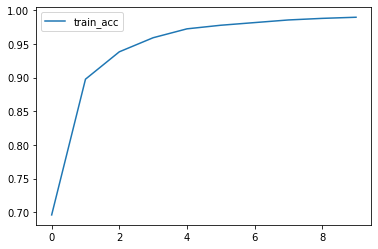

In [23]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()
plt.show()

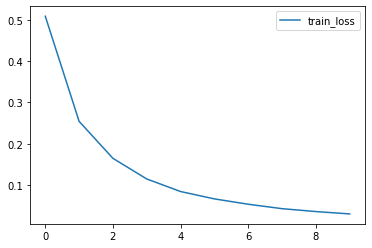

In [24]:
plt.plot(history.history['loss'], label='train_loss')
plt.legend()
plt.show()